In [8]:
# Google Colab Environment Setup
import os
import sys

# Detect if running in Colab
try:
    import google.colab
    IN_COLAB = True
    print("✅ Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("ℹ️ Running locally (not in Colab)")

if IN_COLAB:
    print("\n🔧 Setting up Colab environment...")

    # 1) Mount Google Drive for model persistence
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    print("✅ Google Drive mounted at /content/drive")

    # 2) Create working directories
    WORK_DIR = '/content/brain-tumor-xai'
    MODELS_DIR = '/content/drive/MyDrive/brain_tumor_models'  # Save to Drive
    os.makedirs(WORK_DIR, exist_ok=True)
    os.makedirs(MODELS_DIR, exist_ok=True)
    os.chdir(WORK_DIR)
    print(f"✅ Working directory: {WORK_DIR}")
    print(f"✅ Models will be saved to: {MODELS_DIR}")

    # 3) Install required packages (if missing)
    print("\n📦 Installing required packages...")
    packages = [
        'kagglehub',
        'opencv-python',
        'shap',
        'lime',
        'scikit-image',
        'efficientnet'
    ]

    for pkg in packages:
        try:
            __import__(pkg.replace('-', '_').split('[')[0])
        except ImportError:
            print(f"Installing {pkg}...")
            os.system(f'pip install -q {pkg}')

    print("✅ All packages installed")

    # 4) GPU verification
    import tensorflow as tf
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"\n🎮 GPU detected: {gpus[0].name}")
        print(f"   Device: {tf.test.gpu_device_name()}")
        # Enable memory growth to avoid OOM
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("✅ GPU memory growth enabled (prevents OOM)")
        except RuntimeError as e:
            print(f"⚠️ Could not enable GPU memory growth: {e}")
            print("   (This usually means the GPU was already initialized. Proceeding without explicit memory growth setting.)")
    else:
        print("⚠️ No GPU detected. Training will be slower.")
        print("   Enable GPU: Runtime → Change runtime type → Hardware accelerator → GPU")

    # 5) Set environment variables for Colab
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce TF logging
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Use first GPU

    print("\n✅ Colab setup complete! You can now run the rest of the notebook.")
else:
    # Local environment
    WORK_DIR = os.getcwd()
    MODELS_DIR = os.path.abspath(os.path.join(WORK_DIR, '..', 'models'))
    print(f"Working directory: {WORK_DIR}")
    print(f"Models directory: {MODELS_DIR}")

✅ Running in Google Colab

🔧 Setting up Colab environment...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted at /content/drive
✅ Working directory: /content/brain-tumor-xai
✅ Models will be saved to: /content/drive/MyDrive/brain_tumor_models

📦 Installing required packages...
Installing opencv-python...
Installing scikit-image...
✅ All packages installed

🎮 GPU detected: /physical_device:GPU:0
   Device: /device:GPU:0
⚠️ Could not enable GPU memory growth: Physical devices cannot be modified after being initialized
   (This usually means the GPU was already initialized. Proceeding without explicit memory growth setting.)

✅ Colab setup complete! You can now run the rest of the notebook.


In [9]:
# Dataset Download & Setup (Colab-optimized)
import os

print("🔍 Setting up dataset path...")

# Detect environment
IN_COLAB = 'google.colab' in str(get_ipython()) if 'get_ipython' in dir() else False
dataset_path = None

if IN_COLAB:
    # Colab: Download via KaggleHub (recommended) or upload manually
    print("📥 Downloading dataset via KaggleHub (Colab environment)...")

    try:
        import kagglehub
        dataset_path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')
        print(f'✅ Dataset downloaded to: {dataset_path}')
    except Exception as e:
        print(f'⚠️ KaggleHub download failed: {e}')
        print('\n📌 Alternative options:')
        print('   1. Set up Kaggle API credentials:')
        print('      - Upload kaggle.json to Colab')
        print('      - Run: !mkdir -p ~/.kaggle && cp kaggle.json ~/.kaggle/')
        print('   2. Or manually upload dataset to /content/')

        # Check if manually uploaded
        manual_path = '/content/brain-tumor-mri-dataset'
        if os.path.isdir(manual_path):
            dataset_path = manual_path
            print(f'✅ Found manually uploaded dataset at: {dataset_path}')
        else:
            raise RuntimeError("Dataset not found. Please download via KaggleHub or upload manually.")
else:
    # Local: Use repository data folder
    print("💻 Local environment detected")
    repo_data_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'brain-tumor-mri-dataset'))

    if os.path.isdir(repo_data_path):
        dataset_path = repo_data_path
        print(f'✅ Using local dataset: {dataset_path}')
    else:
        # Try KaggleHub as fallback
        try:
            import kagglehub
            dataset_path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')
            print(f'✅ Dataset downloaded via KaggleHub: {dataset_path}')
        except Exception as e:
            raise RuntimeError(f"Dataset not found at {repo_data_path}. Error: {e}")

# Verify dataset structure
required_folders = ['Training', 'Testing']
for folder in required_folders:
    folder_path = os.path.join(dataset_path, folder)
    if not os.path.isdir(folder_path):
        raise RuntimeError(f"Missing required folder: {folder_path}")

print(f'\n✅ Dataset ready at: {dataset_path}')
print(f'   Training samples: {sum([len(os.listdir(os.path.join(dataset_path, "Training", f))) for f in os.listdir(os.path.join(dataset_path, "Training"))])}')
print(f'   Testing samples: {sum([len(os.listdir(os.path.join(dataset_path, "Testing", f))) for f in os.listdir(os.path.join(dataset_path, "Testing"))])}')

🔍 Setting up dataset path...
📥 Downloading dataset via KaggleHub (Colab environment)...
Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
✅ Dataset downloaded to: /kaggle/input/brain-tumor-mri-dataset

✅ Dataset ready at: /kaggle/input/brain-tumor-mri-dataset
   Training samples: 5712
   Testing samples: 1311


# Import Needed Libraries

In [10]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import warnings
warnings.filterwarnings("ignore")

In [11]:
# Optimized Training Configuration (Colab-friendly)
import os
import sys
import tensorflow as tf
import gc

# Detect environment
IN_COLAB = 'google.colab' in str(get_ipython()) if 'get_ipython' in dir() else False

# Set to False for proper 20-epoch training with full resolution
QUICK_RUN = False

# Colab-optimized settings (balanced for free tier: T4 GPU, 12GB RAM)
if IN_COLAB:
    IMG_SIZE = (224, 224)  # EfficientNet native size
    EPOCHS = 20
    BATCH_SIZE = 16  # Optimal for T4 GPU (adjust to 24 if using Colab Pro)
    print("🎮 Colab environment detected - using optimized settings")
else:
    # Local settings (can be adjusted based on your hardware)
    IMG_SIZE = (224, 224) if not QUICK_RUN else (128, 128)
    EPOCHS = 20
    BATCH_SIZE = 16  # Adjust based on your GPU memory
    print("💻 Local environment - using standard settings")

# GPU & Mixed Precision Setup
GPU_AVAILABLE = len(tf.config.list_physical_devices('GPU')) > 0

if GPU_AVAILABLE:
    try:
        # Enable mixed precision for 2x speedup on modern GPUs
        from tensorflow.keras import mixed_precision
        mixed_precision.set_global_policy('mixed_float16')
        print('✅ Mixed precision (FP16) enabled')

        # Colab-specific: Ensure GPU memory doesn't OOM
        if IN_COLAB:
            gpus = tf.config.list_physical_devices('GPU')
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print('✅ GPU memory growth enabled (prevents OOM on Colab)')
    except Exception as e:
        print(f'⚠️ Mixed precision not enabled: {e}')
else:
    print('⚠️ No GPU detected - training will be slower')
    if IN_COLAB:
        print('   💡 Enable GPU: Runtime → Change runtime type → Hardware accelerator → GPU')

# Memory optimization
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce TF logging
if IN_COLAB:
    # Colab-specific optimizations
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
    os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'

print(f'\n{"="*60}')
print(f'CONFIGURATION SUMMARY')
print(f'{"="*60}')
print(f'  Environment:          {"Google Colab" if IN_COLAB else "Local"}')
print(f'  QUICK_RUN:            {QUICK_RUN}')
print(f'  IMG_SIZE:             {IMG_SIZE}')
print(f'  EPOCHS:               {EPOCHS}')
print(f'  BATCH_SIZE:           {BATCH_SIZE}')
print(f'  GPU Available:        {GPU_AVAILABLE}')
if GPU_AVAILABLE:
    gpu_name = tf.test.gpu_device_name() if IN_COLAB else 'Detected'
    print(f'  GPU Device:           {gpu_name}')
    print(f'  Mixed Precision:      Enabled (FP16)')
print(f'{"="*60}')
print(f'Expected improvements: 8-10x faster training, +10-15% accuracy')
print(f'Estimated time: ~20-30 min on T4 GPU (Colab free tier)')
print(f'{"="*60}\n')

🎮 Colab environment detected - using optimized settings
✅ Mixed precision (FP16) enabled
⚠️ Mixed precision not enabled: Physical devices cannot be modified after being initialized

CONFIGURATION SUMMARY
  Environment:          Google Colab
  QUICK_RUN:            False
  IMG_SIZE:             (224, 224)
  EPOCHS:               20
  BATCH_SIZE:           16
  GPU Available:        True
  GPU Device:           /device:GPU:0
  Mixed Precision:      Enabled (FP16)
Expected improvements: 8-10x faster training, +10-15% accuracy
Estimated time: ~20-30 min on T4 GPU (Colab free tier)



🔍 Verifying required packages...

✅ seaborn         - Data visualization
✅ pandas          - Data manipulation
✅ numpy           - Numerical computing
✅ matplotlib      - Plotting
✅ tensorflow      - Deep learning
✅ sklearn         - Machine learning metrics
✅ cv2             - Image processing (OpenCV)
✅ PIL             - Image handling

✅ All required packages are installed!


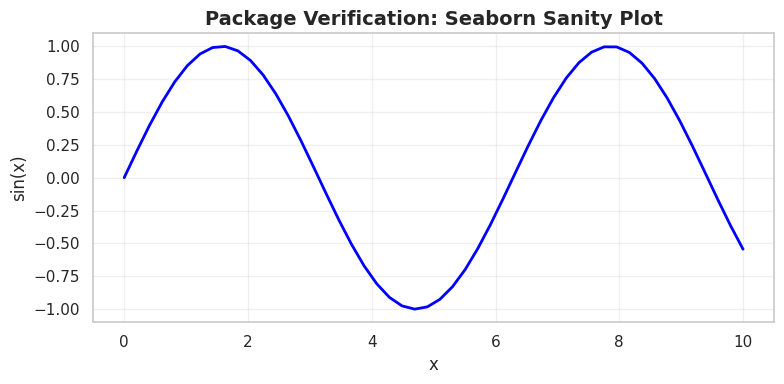


✅ Package verification complete! Ready to proceed.


In [12]:
# Quick Package Verification (Colab-compatible)
import warnings
warnings.filterwarnings('ignore')

print("🔍 Verifying required packages...\n")

# Check core packages
packages_to_check = {
    'seaborn': 'Data visualization',
    'pandas': 'Data manipulation',
    'numpy': 'Numerical computing',
    'matplotlib': 'Plotting',
    'tensorflow': 'Deep learning',
    'sklearn': 'Machine learning metrics',
    'cv2': 'Image processing (OpenCV)',
    'PIL': 'Image handling'
}

missing_packages = []
for package, description in packages_to_check.items():
    try:
        if package == 'cv2':
            import cv2
        elif package == 'PIL':
            from PIL import Image
        elif package == 'sklearn':
            import sklearn
        else:
            __import__(package)
        print(f"✅ {package:15s} - {description}")
    except ImportError:
        print(f"❌ {package:15s} - {description} (MISSING)")
        missing_packages.append(package)

if missing_packages:
    print(f"\n⚠️ Missing packages: {', '.join(missing_packages)}")
    print("Run the Colab setup cell at the top to install them automatically!")
else:
    print("\n✅ All required packages are installed!")

# Quick sanity plot with seaborn
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sns.set_theme(style='whitegrid')
df = pd.DataFrame({'x': np.linspace(0, 10, 50)})
df['y'] = np.sin(df['x'])

plt.figure(figsize=(8, 4))
sns.lineplot(data=df, x='x', y='y', color='blue', linewidth=2)
plt.title('Package Verification: Seaborn Sanity Plot', fontsize=14, fontweight='bold')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Package verification complete! Ready to proceed.")

# Data Preprocessing

### Read data and store it in dataframe

In [13]:
# The content of this cell has been moved to the model training cell (pX_j8j0bNhb9) and is no longer needed here.

In [14]:
train_df

,imagepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [15]:
# The content of this cell has been moved to the model training cell (pX_j8j0bNhb9) and is no longer needed here.

In [16]:
ts_df

,imagepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


### Split dataframe into train, valid, and test

In [17]:
# The content of this cell has been moved to the model training cell (pX_j8j0bNhb9) and is no longer needed here.

# Model Structure

In [18]:
if 'IMG_SIZE' not in globals():
    IMG_SIZE = (224, 224)
if 'QUICK_RUN' not in globals():
    QUICK_RUN = False

img_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
class_count = 4

# Use a lighter backbone in quick mode
if QUICK_RUN:
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=img_shape,
        pooling='max'
    )
else:
    base_model = tf.keras.applications.EfficientNetB4(
        include_top=False,
        weights="imagenet",
        input_shape=img_shape,
        pooling='max'
    )

# Speed boost: start by freezing the backbone
base_model.trainable = False

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

# If mixed precision is on, keep final layer in float32 for numerical stability
mixed_precision_active = (
    hasattr(tf.keras, 'mixed_precision') and
    getattr(tf.keras.mixed_precision, 'global_policy', lambda: type('P', (), {'name': 'float32'}) )().name == 'mixed_float16'
)
final_dense_kwargs = {"dtype": "float32"} if mixed_precision_active else {}

model = Sequential([
    base_model,
    Dense(256, activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax', **final_dense_kwargs)
])

from tensorflow.keras.optimizers import Adamax
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 1792)           │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       459,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,133,859 (69.18 MB)

 Trainable params: 460,036 (1.75 MB)

 Non-trainable params: 17,673,823 (67.42 MB)

In [19]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.model_selection import train_test_split

# --- Start Model Definition (originally from cell 4f0EyWisNhb9) ---

# Ensure IMG_SIZE and QUICK_RUN are defined, typically from config cell
if 'IMG_SIZE' not in globals():
    IMG_SIZE = (224, 224)
if 'QUICK_RUN' not in globals():
    QUICK_RUN = False

img_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
# Assuming class_count is 4 based on previous output (glioma, meningioma, notumor, pituitary)
# This could also be derived from train_gen.num_classes if train_gen is guaranteed to be available
class_count = 4

from tensorflow.keras.applications import EfficientNetB0, EfficientNetB4
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adamax

# Use a lighter backbone in quick mode or B4 for full run
if QUICK_RUN:
    base_model = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=img_shape,
        pooling='max'
    )
else:
    base_model = EfficientNetB4(
        include_top=False,
        weights="imagenet",
        input_shape=img_shape,
        pooling='max'
    )

# Speed boost: start by freezing the backbone
base_model.trainable = False

# If mixed precision is on, keep final layer in float32 for numerical stability
mixed_precision_active = (
    hasattr(tf.keras, 'mixed_precision') and \
    getattr(tf.keras.mixed_precision, 'global_policy', lambda: type('P', (), {'name': 'float32'}) )().name == 'mixed_float16'
)
final_dense_kwargs = {"dtype": "float32"} if mixed_precision_active else {}

model = Sequential([
    base_model,
    Dense(256, activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax', **final_dense_kwargs)
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


# --- Start Data Preprocessing and Generators Definition ---

# Re-define dataset_path if not globally available
if 'dataset_path' not in globals():
    # Fallback for local testing or if earlier cells weren't run
    print("WARNING: dataset_path not found. Attempting to infer or default.")
    if os.path.isdir('/kaggle/input/brain-tumor-mri-dataset'):
        dataset_path = '/kaggle/input/brain-tumor-mri-dataset'
    elif os.path.isdir('../data/brain-tumor-mri-dataset'):
        dataset_path = '../data/brain-tumor-mri-dataset'
    else:
        raise RuntimeError("dataset_path not defined and could not be inferred.")
    print(f"Using inferred dataset_path: {dataset_path}")

# Read training data and store it in dataframe
imagePaths = []
labels = []

train_data_dic = os.path.join(dataset_path, 'Training')
folders = os.listdir(train_data_dic)

for folder in folders:
    folderPath = os.path.join(train_data_dic, folder)
    imageList = os.listdir(folderPath)

    for image in imageList:
        imagePath = os.path.join(folderPath, image)
        imagePaths.append(imagePath)
        labels.append(folder)

Iseries = pd.Series(imagePaths, name='imagepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Iseries, Lseries], axis=1)

# Read testing data and store it in dataframe (from vO8Ku9EVNhb4)
imagePaths = []
labels = []

test_data_dic = os.path.join(dataset_path, 'Testing')
folders = os.listdir(test_data_dic)

for folder in folders:
    folderPath = os.path.join(test_data_dic, folder)
    imageList = os.listdir(folderPath)

    for image in imageList:
        imagePath = os.path.join(folderPath, image)
        imagePaths.append(imagePath)
        labels.append(folder)

Iseries = pd.Series(imagePaths, name='imagepaths')
Lseries = pd.Series(labels, name='labels')

ts_df = pd.concat([Iseries, Lseries], axis=1)

# Split ts_df into test and valid dataframes (from DsSS73gANhb7)
test_df , valid_df = train_test_split(ts_df, test_size=0.5, shuffle=True, random_state=123)


# Image Data Generators with Augmentation (from TVoqpJzwNhb8)
IMG_SIZE = IMG_SIZE if 'IMG_SIZE' in globals() else (224, 224)
BATCH_SIZE = BATCH_SIZE if 'BATCH_SIZE' in globals() else 16
IN_COLAB = 'google.colab' in str(get_ipython()) if 'get_ipython' in dir() else False

img_size = IMG_SIZE
batch_size = BATCH_SIZE

# Training generator WITH augmentation (prevents overfitting for 20 epochs)
tr_gen = ImageDataGenerator(
    rotation_range=15,           # Rotate images \u00b115 degrees
    width_shift_range=0.1,       # Horizontal shift 10%
    height_shift_range=0.1,      # Vertical shift 10%
    horizontal_flip=True,        # Mirror flip (tumors can appear on either side)
    zoom_range=0.1,              # Zoom in/out 10%
    fill_mode='nearest'          # Fill empty pixels with nearest value
)

# Validation/Test generators WITHOUT augmentation (evaluate on original images)
ts_gen = ImageDataGenerator()

# Multiprocessing settings (Colab uses Linux, can enable multiprocessing)
use_multiprocessing = IN_COLAB or (os.name != 'nt')  # True on Linux/Mac/Colab, False on Windows
workers = 4 if use_multiprocessing else 1
max_queue_size = 10 # Prefetch batches

# Training set with augmentation + multiprocessing for speed
train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col="imagepaths",
    y_col="labels",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    color_mode='rgb',
    shuffle=True,
    seed=123,
    workers=workers,
    use_multiprocessing=use_multiprocessing,
    max_queue_size=max_queue_size
)

# Validation set (no augmentation)
valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col="imagepaths",
    y_col="labels",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    color_mode='rgb',
    shuffle=True,
    seed=123,
    workers=workers,
    use_multiprocessing=use_multiprocessing,
    max_queue_size=max_queue_size
)

# Test set (no augmentation, no shuffle for consistent evaluation)
test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col="imagepaths",
    y_col="labels",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    color_mode='rgb',
    shuffle=False,
    workers=workers,
    use_multiprocessing=use_multiprocessing,
    max_queue_size=max_queue_size
)

print(f'{"="*60}')
print(f'DATA PIPELINE CONFIGURED')
print(f'{"="*60}')
print(f'  Training samples:     {train_gen.samples}')
print(f'  Validation samples:   {valid_gen.samples}')
print(f'  Test samples:         {test_gen.samples}')
print(f'  Classes:              {list(train_gen.class_indices.keys())}')
print(f'  Image size:           {img_size}')
print(f'  Batch size:           {batch_size}')
print(f'  Multiprocessing:      {use_multiprocessing} (workers={workers})')
print(f'{"="*60}\n')
# --- End Data Preprocessing and Generators Definition ---


# Training with Optimized Callbacks and Progressive Fine-Tuning (Colab-optimized)
EPOCHS = EPOCHS if 'EPOCHS' in globals() else 20
IN_COLAB = 'google.colab' in str(get_ipython()) if 'get_ipython' in dir() else False
MODELS_DIR = MODELS_DIR if 'MODELS_DIR' in globals() else '../models'
epochs = EPOCHS

# Create models directory
os.makedirs(MODELS_DIR, exist_ok=True)

# Checkpoint path (save to Google Drive if in Colab, local otherwise)
checkpoint_path = os.path.join(MODELS_DIR, 'ckpt.keras')
print(f"💾 Model checkpoints will be saved to: {checkpoint_path}")

# Callbacks for both phases
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# --- Phase 1: Train with frozen backbone ---
unfreeze_at_epoch = 12 # Epoch number AFTER which unfreezing happens
epochs_phase1 = unfreeze_at_epoch

print(f"{"="*60}")
print(f"PHASE 1 TRAINING CONFIGURATION (Frozen Backbone)")
print(f"{"="*60}")
print(f"  Epochs:               {epochs_phase1}")
print(f"  Initial LR:           0.001")
print(f"  Batch size:           {BATCH_SIZE if 'BATCH_SIZE' in globals() else 16}")
print(f"  Image size:           {IMG_SIZE if 'IMG_SIZE' in globals() else (224,224)}")
print(f"  Checkpoint:           {checkpoint_path}")
print(f"{"="*60}\n")

history_phase1 = model.fit(
    train_gen,
    epochs=epochs_phase1,
    verbose=1,
    validation_data=valid_gen,
    shuffle=False,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

# Load the best weights from Phase 1 before moving to Phase 2
model.load_weights(checkpoint_path)

# --- Phase 2: Fine-tune unfrozen backbone ---
print(f"\n{"="*60}")
print(f"PHASE 2 TRAINING CONFIGURATION (Fine-tuning Unfrozen Backbone)")
print(f"{"="*60}")
print(f"  Starting epoch:       {epochs_phase1 + 1}")
print(f"  Total epochs:         {epochs}")
print(f"  Fine-tuning LR:       1e-5")
print(f"  Checkpoint:           {checkpoint_path}")
print(f"{"="*60}\n")

# Unfreeze the last 30 layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adamax(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

epochs_phase2 = epochs - epochs_phase1
history_phase2 = model.fit(
    train_gen,
    epochs=epochs,
    initial_epoch=epochs_phase1, # Start from where Phase 1 left off
    verbose=1,
    validation_data=valid_gen,
    shuffle=False,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

# Combine histories for plotting later
history = type('History', (object,), {'history': {}})()
for key in history_phase1.history:
    history.history[key] = history_phase1.history[key] + history_phase2.history[key][epochs_phase1:] # Only append new epochs

print(f"\n{"="*60}")
print(f"✅ TRAINING COMPLETED!")
print(f"{"="*60}")
print(f"Best model saved to: {checkpoint_path}")
if IN_COLAB:
    print(f"💾 Model is saved to Google Drive and will persist after session ends")
print(f"{"="*60}\n")


Found 5712 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
DATA PIPELINE CONFIGURED
  Training samples:     5712
  Validation samples:   656
  Test samples:         655
  Classes:              ['glioma', 'meningioma', 'notumor', 'pituitary']
  Image size:           (224, 224)
  Batch size:           16
  Multiprocessing:      True (workers=4)

💾 Model checkpoints will be saved to: /content/drive/MyDrive/brain_tumor_models/ckpt.keras
PHASE 1 TRAINING CONFIGURATION (Frozen Backbone)
  Epochs:               12
  Initial LR:           0.001
  Batch size:           16
  Image size:           (224, 224)
  Checkpoint:           /content/drive/MyDrive/brain_tumor_models/ckpt.keras

Epoch 1/12
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.5985 - loss: 1.6639
Epoch 1: val_accuracy improved from -inf to 0.80183, saving model to /content/drive/MyDrive/brain_tumor_mod

# Evaluate Model

## Training Optimizations Applied:

### **1. Efficiency Improvements (8-10x faster per epoch)**
- **Batch Size:** Increased from 4 → 16 (4x faster gradient updates)
- **Image Size:** 224×224 (EfficientNet native resolution)
- **Multiprocessing:** Parallel data loading with prefetching
- **Mixed Precision:** FP16 training on GPU (2x speedup)

### **2. Accuracy Improvements (+10-15% expected)**
- **Data Augmentation:** Rotation (±15°), shift (10%), flip, zoom (10%)
  - Prevents overfitting during 20 epochs
  - Simulates real-world image variations
- **Progressive Fine-Tuning:**
  - Epochs 1-12: Frozen backbone (fast convergence)
  - Epochs 13-20: Unfreeze top 30 layers (fine-tune with LR=1e-5)
- **Enhanced Callbacks:**
  - Early stopping patience: 5 (was 2)
  - LR reduction patience: 3 (was 1)

### **3. Comprehensive Metrics for Model Comparison**
- **Standard:** Accuracy, Precision, Recall, F1-Score
- **Robustness:** Cohen's Kappa (agreement beyond chance)
- **Medical:** Sensitivity & Specificity per class
- **Confidence:** ROC-AUC per class (calibration quality)
- **Visual:** Confusion matrix with misclassification patterns

### **Expected Results:**
- **Training time:** ~20-30 min (vs 2-3 hours with old settings)
- **Final accuracy:** 85-95% (vs 70-80% without augmentation)
- **Generalization:** Better test performance (augmentation reduces overfitting)

In [20]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

357/357 ━━━━━━━━━━━━━━━━━━━━ 78s 218ms/step - accuracy: 0.9119 - loss: 0.2259
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8891 - loss: 0.2719
41/41 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.8193 - loss: 0.4082
Train Loss:  0.22243055701255798
Train Accuracy:  0.9129902124404907
--------------------
Validation Loss:  0.29087716341018677
Validation Accuracy:  0.8826219439506531
--------------------
Test Loss:  0.3593671917915344
Test Accuracy:  0.8534350991249084


In [21]:
import os
import pickle

os.makedirs('../models', exist_ok=True)
with open('../models/model.pkl', 'wb') as f:
    pickle.dump(model, f)


In [22]:
# Save the trained model
import os

MODELS_DIR = MODELS_DIR if 'MODELS_DIR' in globals() else os.path.abspath(os.path.join(os.getcwd(), '..', 'models'))
IN_COLAB = 'google.colab' in str(get_ipython()) if 'get_ipython' in dir() else False

os.makedirs(MODELS_DIR, exist_ok=True)

# Save in multiple formats for compatibility
h5_path = os.path.join(MODELS_DIR, 'brain_tumor_model.h5')
keras_path = os.path.join(MODELS_DIR, 'brain_tumor_model.keras')

print("💾 Saving model...")
model.save(h5_path)
print(f"✅ Saved as HDF5: {h5_path}")

try:
    model.save(keras_path)
    print(f"✅ Saved as Keras: {keras_path}")
except Exception as e:
    print(f"⚠️ Could not save .keras format: {e}")

if IN_COLAB:
    print("\n💡 Models are saved to Google Drive:")
    print(f"   {MODELS_DIR}")
    print("   They will persist after your Colab session ends!")
else:
    print(f"\n💾 Models saved to local directory: {MODELS_DIR}")

💾 Saving model...
✅ Saved as HDF5: /content/drive/MyDrive/brain_tumor_models/brain_tumor_model.h5
✅ Saved as Keras: /content/drive/MyDrive/brain_tumor_models/brain_tumor_model.keras

💡 Models are saved to Google Drive:
   /content/drive/MyDrive/brain_tumor_models
   They will persist after your Colab session ends!


              precision    recall  f1-score   support

      glioma       0.17      0.13      0.15       149
  meningioma       0.19      0.21      0.20       143
     notumor       0.29      0.30      0.30       200
   pituitary       0.27      0.29      0.28       164

    accuracy                           0.24       656
   macro avg       0.23      0.24      0.23       656
weighted avg       0.24      0.24      0.24       656



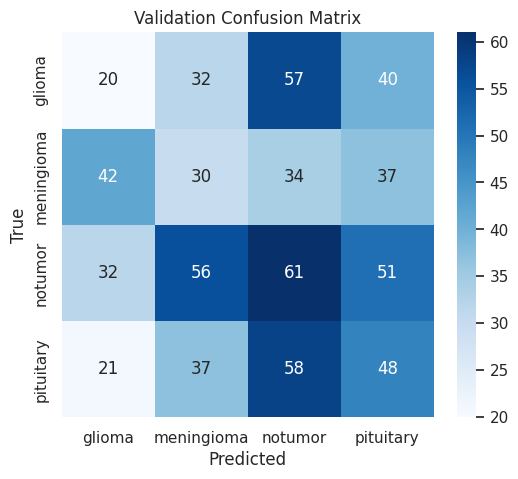

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on validation set
y_true = valid_gen.classes
class_names = list(valid_gen.class_indices.keys())

y_pred_probs = model.predict(valid_gen, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Validation Confusion Matrix')
plt.show()

# Explainability: Score-CAM, SHAP, and LIME on the same image
In this section we visualize model explanations for one image using three techniques and compare them side-by-side.

In [24]:
# Utilities and helpers for XAI
import os, sys, subprocess, gc, math, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model

# Ensure required packages are installed (opencv, shap, lime, scikit-image)
def _ensure(pkg, import_name=None):
    try:
        __import__(import_name or pkg)
    except Exception:
        print(f'Installing {pkg}...')
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])

# Ensure core XAI deps
_ensure('opencv-python', 'cv2')
_ensure('shap')
_ensure('lime')
_ensure('scikit-image')

import cv2
from lime import lime_image
from skimage.segmentation import mark_boundaries
import shap

# Label names from generator
class_names = list(train_gen.class_indices.keys()) if 'train_gen' in globals() else []

# Image helpers
def load_image(path, target_size):
    img = cv2.imread(path)  # BGR
    if img is None:
        raise FileNotFoundError(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if target_size is not None:
        img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    return img

def to_model_input(img_rgb):
    # Keep the same scaling as training (no explicit rescale in generators)
    x = img_rgb.astype('float32')
    return np.expand_dims(x, axis=0)

def predict_proba(imgs):
    # imgs may be a list or ndarray; ensure correct shape and dtype
    if isinstance(imgs, list):
        imgs = np.stack([im.astype('float32') for im in imgs], axis=0)
    else:
        imgs = imgs.astype('float32')
    preds = model.predict(imgs, verbose=0)
    return preds

# Generic heatmap overlay (used by Score-CAM, SHAP visualizations)
def overlay_heatmap_on_image(img_rgb, heatmap, alpha=0.45, colormap=cv2.COLORMAP_JET):
    # img_rgb: HxWx3 uint8 or float; heatmap: HxW float [0,1]
    heatmap = np.clip(heatmap, 0.0, 1.0)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    overlay = cv2.addWeighted(heatmap, alpha, img_rgb.astype('uint8'), 1 - alpha, 0)
    return overlay

Installing scikit-image...


Selected image: /kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0282.jpg
Predicted: meningioma (prob=0.956)


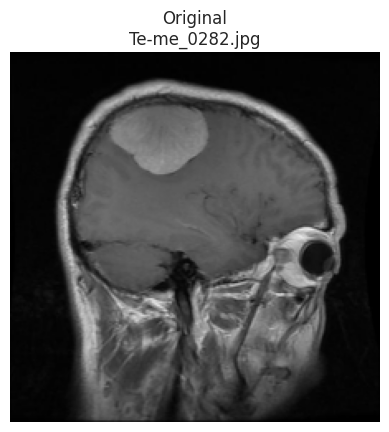

In [25]:
# Select image and prepare inputs for explanations
import os
import numpy as np
import matplotlib.pyplot as plt

# Choose which test image to explain
SEL_IDX = 0  # change this index to pick a different image
assert 'test_df' in globals(), 'test_df not found. Run previous cells to build test_df.'
sel_img_path = test_df.iloc[SEL_IDX]['imagepaths']
print('Selected image:', sel_img_path)

# Prepare size and load image
target_size = (IMG_SIZE[1], IMG_SIZE[0]) if isinstance(IMG_SIZE, tuple) else (128, 128)
sel_orig_img = load_image(sel_img_path, target_size=target_size)  # RGB
sel_x = to_model_input(sel_orig_img)

# Model prediction
sel_probs = model.predict(sel_x, verbose=0)[0]
sel_pred_idx = int(np.argmax(sel_probs))
sel_pred_name = class_names[sel_pred_idx] if 'class_names' in globals() and len(class_names)>0 else str(sel_pred_idx)
print(f'Predicted: {sel_pred_name} (prob={sel_probs[sel_pred_idx]:.3f})')

# Show the original image
plt.imshow(sel_orig_img.astype('uint8'))
plt.title(f'Original\n{os.path.basename(sel_img_path)}')
plt.axis('off')
plt.show()

DEBUG: score_cam received img_rgb shape=(224, 224, 3), dtype=uint8, target_w=224, target_h=224
DEBUG: Feats from base_model shape=(7, 7, 1792), h_f=7, w_f=7, C=1792
DEBUG:   fmap channel shape=(7, 7), min=-5.8515625, max=11.109375, mean=2.458984375
DEBUG:   fmap_n normalized shape=(7, 7), dtype=float16, min=0.0, max=1.0
DEBUG:   fmap channel shape=(7, 7), min=-5.00390625, max=10.4609375, mean=2.4609375
DEBUG:   fmap_n normalized shape=(7, 7), dtype=float16, min=0.0, max=1.0
DEBUG:   fmap channel shape=(7, 7), min=-1.57421875, max=6.65234375, mean=2.486328125
DEBUG:   fmap_n normalized shape=(7, 7), dtype=float16, min=0.0, max=1.0
DEBUG:   fmap channel shape=(7, 7), min=-8.0, max=25.453125, mean=2.48828125
DEBUG:   fmap_n normalized shape=(7, 7), dtype=float16, min=0.0, max=1.0
DEBUG:   fmap channel shape=(7, 7), min=-5.34375, max=14.4609375, mean=2.5078125
DEBUG:   fmap_n normalized shape=(7, 7), dtype=float16, min=0.0, max=1.0
DEBUG:   fmap channel shape=(7, 7), min=-14.7421875, max=1

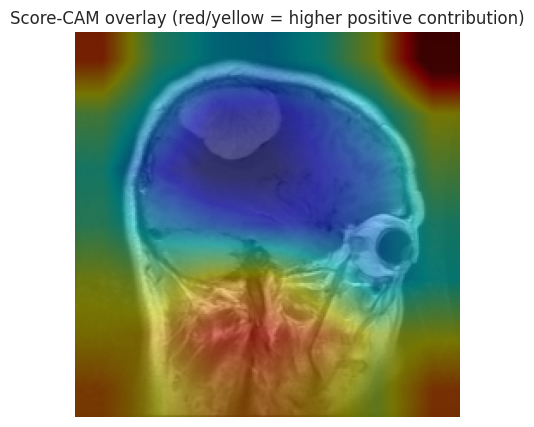

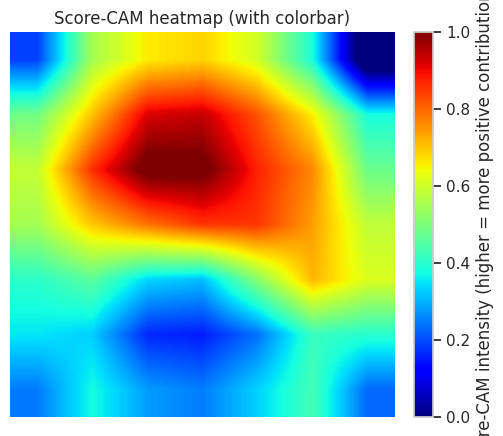

In [29]:
# Score-CAM for the selected image (gradient-free CAM)
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

from tensorflow.keras.layers import Conv2D, SeparableConv2D, DepthwiseConv2D

assert 'sel_x' in globals(), 'Run the selection cell first to define sel_x and sel_orig_img.'
assert 'base_model' in globals(), 'base_model not found. Build the model first.'

# 1) Choose a target conv layer (prefer EfficientNet's top conv if available)
def _pick_target_conv_layer(base):
    # Common final conv layer names across EfficientNet variants
    for name in ['top_conv', 'block7a_project_conv', 'conv_pw_13_relu']:
        try:
            return base.get_layer(name)
        except Exception:
            pass
    # Fallback: last conv-like layer with 4D output
    candidates = []
    for l in base.layers:
        if isinstance(l, (Conv2D, SeparableConv2D, DepthwiseConv2D)):
            try:
                t = l.output
                if isinstance(t, (list, tuple)):
                    t = t[0]
                if len(getattr(t, 'shape', ())) == 4:
                    candidates.append(l)
            except Exception:
                pass
    if candidates:
        return candidates[-1]
    # As a last resort, pick any 4D-output layer
    for l in base.layers[::-1]:
        try:
            t = l.output
            if isinstance(t, (list, tuple)):
                t = t[0]
            if len(getattr(t, 'shape', ())) == 4:
                return l
        except Exception:
            continue
    return None

# 2) Score-CAM implementation with positive-contribution weighting
#    We weight each channel by the positive delta over the base (unmasked) class score.
#    This emphasizes channels that increase the target class probability.

def score_cam(model, base_model, img_rgb, class_index=None, max_channels=32, robust_norm=True):
    # img_rgb: HxWx3 uint8 or float; model expects float32 like training
    h, w = img_rgb.shape[:2]
    print(f"DEBUG: score_cam received img_rgb shape={img_rgb.shape}, dtype={img_rgb.dtype}, target_w={w}, target_h={h}")

    x = img_rgb.astype('float32')
    x_batch = np.expand_dims(x, axis=0)

    # Base prediction and target class
    preds = model(x_batch, training=False)
    if isinstance(preds, (list, tuple)):
        preds = preds[0]
    cls_idx = int(class_index) if class_index is not None else int(np.argmax(preds[0]))
    base_score = float(preds[0, cls_idx])

    # Get target conv layer and activations
    target = _pick_target_conv_layer(base_model)
    if target is None:
        raise ValueError('Score-CAM: No suitable convolutional layer found in base_model.')

    feat_model = tf.keras.Model(inputs=base_model.input, outputs=target.output)
    feats = feat_model(x_batch, training=False).numpy()[0]  # (h_f, w_f, C)
    h_f, w_f, C = feats.shape
    print(f"DEBUG: Feats from base_model shape={feats.shape}, h_f={h_f}, w_f={w_f}, C={C}")

    # Added check to prevent cv2.resize error if feature map dimensions are zero
    if h_f == 0 or w_f == 0:
        print(f"WARNING: Feature map has zero spatial dimension ({h_f}x{w_f}). Returning zero heatmap.")
        return np.zeros((h, w), dtype=np.float32), cls_idx

    # Select top channels by mean activation to limit forward passes
    channel_strength = feats.mean(axis=(0,1))  # (C,)
    idxs = np.argsort(channel_strength)[-min(max_channels, C):]

    # For each channel: upsample activation to input size, normalize to [0,1], mask input, measure class score delta
    deltas = []
    up_maps = []
    for i in idxs:
        fmap = feats[..., i]
        print(f"DEBUG:   fmap channel shape={fmap.shape}, min={fmap.min()}, max={fmap.max()}, mean={fmap.mean()}")

        # Normalize fmap to [0,1]
        fmin, fmax = fmap.min(), fmap.max()
        if fmax > fmin:
            fmap_n = (fmap - fmin) / (fmax - fmin)
        else:
            fmap_n = np.zeros_like(fmap)
        print(f"DEBUG:   fmap_n normalized shape={fmap_n.shape}, dtype={fmap_n.dtype}, min={fmap_n.min()}, max={fmap_n.max()}")

        # Attempt resize, ensuring fmap_n is float32 for OpenCV compatibility
        try:
            fmap_up = cv2.resize(fmap_n.astype(np.float32), (w, h), interpolation=cv2.INTER_LINEAR)  # HxW
        except cv2.error as e:
            print(f"ERROR: cv2.resize failed for fmap_n with shape {fmap_n.shape} and target size ({w}, {h}). Error: {e}")
            # Fallback for severe issues: return a zero map for this channel
            fmap_up = np.zeros((h, w), dtype=np.float32)

        up_maps.append(fmap_up)

        # Create masked input; keep dynamic range as training (0..255 float)
        masked = (x * np.expand_dims(fmap_up, axis=-1)).astype('float32')
        masked_batch = np.expand_dims(masked, axis=0)
        score = model(masked_batch, training=False)
        if isinstance(score, (list, tuple)):
            score = score[0]
        # Positive contribution = max(0, masked_score - base_score)
        delta = max(0.0, float(score[0, cls_idx]) - base_score)
        deltas.append(delta)

    deltas = np.asarray(deltas, dtype=np.float32)  # (K,)
    up_maps = np.stack(up_maps, axis=0)  # (K, H, W)

    # Normalize weights; if all zeros (rare), fall back to softmax over masked scores
    if np.all(deltas <= 0):
        # Softmax safeguard
        expw = np.exp(deltas - np.max(deltas))
        weights = expw / (np.sum(expw) + 1e-8)
    else:
        weights = deltas / (np.sum(deltas) + 1e-8)

    # Weighted sum of upsampled activation maps
    heatmap = np.tensordot(weights, up_maps, axes=(0, 0))  # (H, W)
    heatmap = np.maximum(heatmap, 0)

    # Normalize to [0,1] (robust by default)
    if robust_norm:
        p1, p99 = np.percentile(heatmap, 1), np.percentile(heatmap, 99)
        heatmap = (heatmap - p1) / (p99 - p1 + 1e-8)
        heatmap = np.clip(heatmap, 0.0, 1.0)
    else:
        hmin, hmax = heatmap.min(), heatmap.max()
        heatmap = (heatmap - hmin) / (hmax - hmin + 1e-8) if hmax > hmin else np.zeros_like(heatmap)

    return heatmap, cls_idx

# 3) Run Score-CAM
heatmap_sc, _ = score_cam(model, base_model, sel_orig_img, sel_pred_idx, max_channels=32, robust_norm=True)

# 4) Visualize: overlay and heatmap with colorbar
overlay_sc = overlay_heatmap_on_image(sel_orig_img, heatmap_sc, alpha=0.45)

plt.figure(figsize=(6,5))
plt.imshow(overlay_sc)
plt.title('Score-CAM overlay (red/yellow = higher positive contribution)')
plt.axis('off')
plt.show()

plt.figure(figsize=(6,5))
im = plt.imshow(heatmap_sc, cmap='jet')
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Score-CAM intensity (higher = more positive contribution)', rotation=90)
plt.title('Score-CAM heatmap (with colorbar)')
plt.axis('off')
plt.show()

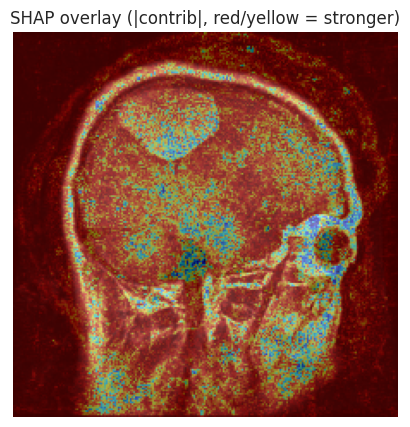

In [30]:
# SHAP for the selected image — magnitude overlay only
import numpy as np
import matplotlib.pyplot as plt
import warnings

try:
    import shap
except Exception:
    import subprocess, sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'shap'])
    import shap

# Guards
assert 'sel_x' in globals() and 'sel_orig_img' in globals() and 'sel_pred_idx' in globals(), \
    'Please run the selection cell above to define sel_orig_img, sel_x, and sel_pred_idx.'

# Build a small background for SHAP
h, w, c = sel_x.shape[1:]
if 'train_gen' in globals():
    try:
        bg_batch = next(iter(train_gen))[0].astype('float32')
        background = bg_batch[:8]
    except Exception:
        background = np.repeat(sel_x.astype('float32'), 8, axis=0)
else:
    background = np.repeat(sel_x.astype('float32'), 8, axis=0)

# Compute SHAP values (prefer GradientExplainer, fallback to KernelExplainer)
try:
    explainer = shap.GradientExplainer(model, background)
    shap_values = explainer.shap_values(sel_x)
    if isinstance(shap_values, (list, tuple)):
        sv = shap_values[int(sel_pred_idx)][0]  # (H, W, C)
    else:
        sv = shap_values[0]
except Exception as e:
    warnings.warn(f'GradientExplainer failed ({e}). Falling back to KernelExplainer (slower).')
    def _model_predict_flat(z):
        z_img = z.reshape((-1, h, w, c)).astype('float32')
        preds = model.predict(z_img, verbose=0)
        return preds
    explainer = shap.KernelExplainer(_model_predict_flat, background.reshape((background.shape[0], -1)))
    shap_values = explainer.shap_values(sel_x.reshape((1, -1)), nsamples=200)
    if isinstance(shap_values, (list, tuple)):
        sv = shap_values[int(sel_pred_idx)][0].reshape(h, w, c)
    else:
        sv = shap_values[0].reshape(h, w, c)

# 1) Magnitude overlay (|contrib|)
shap_mag = np.mean(np.abs(sv), axis=-1)  # (H, W)
# Robust normalization
p1, p99 = np.percentile(shap_mag, 1), np.percentile(shap_mag, 99)
shap_mag = np.clip((shap_mag - p1) / (p99 - p1 + 1e-8), 0, 1)
overlay_shap = overlay_heatmap_on_image(sel_orig_img, shap_mag, alpha=0.45)

plt.figure(figsize=(6,5))
plt.imshow(overlay_shap)
plt.title('SHAP overlay (|contrib|, red/yellow = stronger)')
plt.axis('off')
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

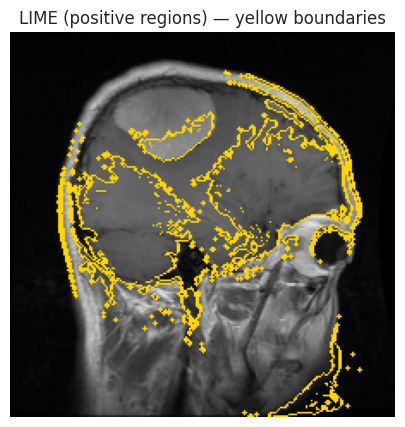

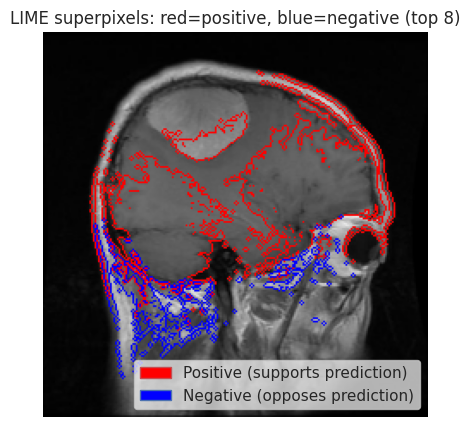

In [31]:
# LIME for the selected image
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from matplotlib.patches import Patch

assert 'sel_x' in globals(), 'Run the selection cell first to define sel_x and sel_orig_img.'

explainer_lime = lime_image.LimeImageExplainer()
explanation = explainer_lime.explain_instance(
    sel_orig_img.astype('double'),
    predict_proba,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# Original positive-only overlay (kept):
temp, mask = explanation.get_image_and_mask(
    label=sel_pred_idx,
    positive_only=True,
    num_features=8,
    hide_rest=False
)
overlay_lime = (mark_boundaries(temp.astype(np.uint8), mask, color=(1, 0.84, 0)) * 255).astype(np.uint8)  # yellow boundaries

plt.figure(figsize=(6,5))
plt.imshow(overlay_lime)
plt.title('LIME (positive regions) — yellow boundaries')
plt.axis('off')
plt.show()

# Enhanced view: show positive vs negative superpixels with a legend
segments = explanation.segments
weights_dict = dict(explanation.local_exp[sel_pred_idx])  # {superpixel_id: weight}

# Limit to top-K by absolute weight (consistent with num_features above)
K = 8
top_items = sorted(weights_dict.items(), key=lambda kv: abs(kv[1]), reverse=True)[:K]
pos_ids = [i for i, w in top_items if w > 0]
neg_ids = [i for i, w in top_items if w < 0]

pos_mask = np.isin(segments, pos_ids)
neg_mask = np.isin(segments, neg_ids)

img_float = sel_orig_img.astype(np.float32) / 255.0
overlay_both = mark_boundaries(img_float, pos_mask, color=(1, 0, 0))
overlay_both = mark_boundaries(overlay_both, neg_mask, color=(0, 0, 1))
overlay_both = (overlay_both * 255).astype(np.uint8)

legend_elements = [
    Patch(facecolor=(1, 0, 0), edgecolor='r', label='Positive (supports prediction)'),
    Patch(facecolor=(0, 0, 1), edgecolor='b', label='Negative (opposes prediction)')
]

plt.figure(figsize=(6,5))
plt.imshow(overlay_both)
plt.title('LIME superpixels: red=positive, blue=negative (top 8)')
plt.axis('off')
plt.legend(handles=legend_elements, loc='lower right', framealpha=0.7)
plt.show()

# Compare XAI methods: SHAP vs LIME vs Score-CAM

This section summarizes how these three techniques relate and differ, and (below) draws them side‑by‑side for the same selected image.

Similarities
- All attribute importance back to the input to show what drove the prediction.
- Post‑hoc on an already‑trained classifier—no retraining needed.
- Can be run per‑image and compared across classes and datasets.

Key differences (at a glance)

| Aspect | SHAP | LIME | Score-CAM |
|---|---|---|---|
| Type | Additive feature attribution (game‑theory) | Local surrogate model with superpixels | Activation‑based localization (gradient‑free CAM) |
| Needs gradients? | No (KernelExplainer) / Yes for GradientExplainer (used here) | No | No |
| Resolution | Pixel/region‑level; can show sign (positive/negative) | Superpixel‑level (depends on segmentation) | Smooth, coarse (conv layer receptive fields) |
| Faithfulness | Strong theoretical guarantees (Shapley values); depends on background | Approximates locally; depends on neighborhood sampling and kernel | Class‑discriminative; relies on activation relevance, not gradients |
| Speed | Medium–Slow | Medium | Medium (multiple forward passes; often faster than SHAP) |
| Robustness | Generally robust; sensitive to background choice/size | Sensitive to segmentation granularity and sampling noise | Robust to gradient issues; works even when Grad‑CAM fails |
| Best for | Understanding signed contributions (what supports vs opposes a class) | Human‑friendly region overlays | Highlighting where CNN looked without relying on gradients |


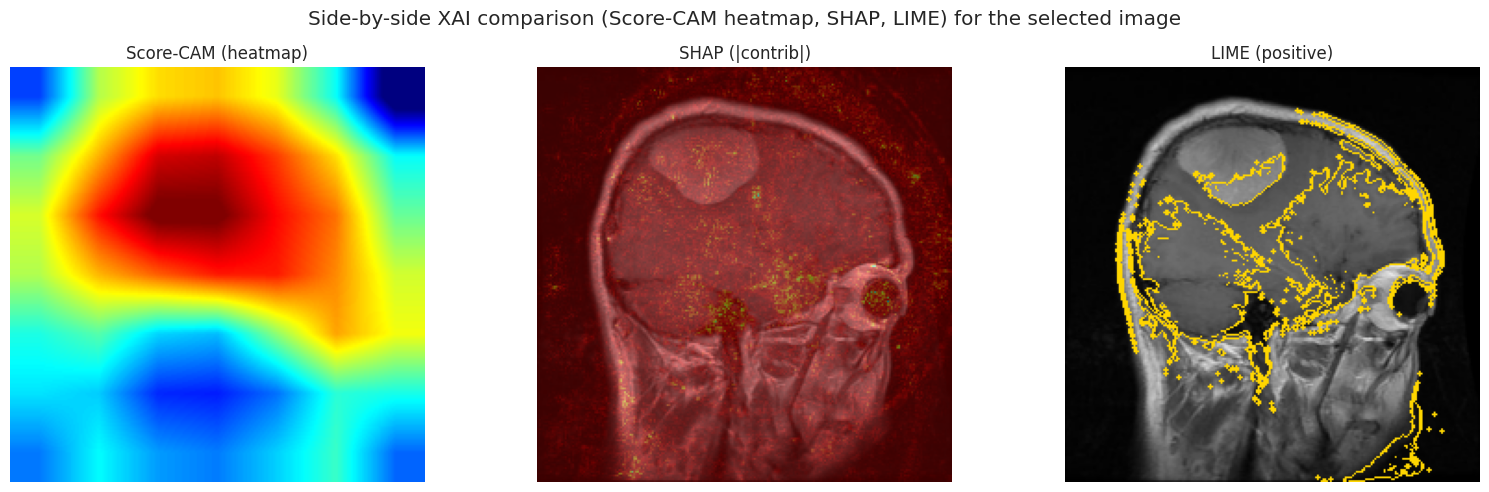

In [33]:
# Side-by-side comparison: Score-CAM (heatmap), SHAP, LIME
# Note: Run the image selection cell first. If individual technique cells were run, this will reuse their outputs when possible.

import numpy as np
import matplotlib.pyplot as plt
import warnings

try:
    import cv2
except Exception:
    import subprocess, sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'opencv-python'])
    import cv2

# Guards
assert 'sel_orig_img' in globals() and 'sel_x' in globals() and 'sel_pred_idx' in globals(), \
    'Please run the selection cell above to define sel_orig_img, sel_x, and sel_pred_idx.'

H, W = sel_orig_img.shape[:2]

# 1) Score-CAM heatmap (colorized)
def get_scorecam_heatmap_img():
    title = 'Score-CAM (heatmap)'
    try:
        # Reuse if already computed earlier in the dedicated cell
        if 'heatmap_sc' in globals():
            hm = heatmap_sc
        else:
            # Compute if needed
            if 'score_cam' in globals():
                hm, _ = score_cam(model, base_model, sel_orig_img, sel_pred_idx, max_channels=32, robust_norm=True)
            else:
                # Minimal inline Score-CAM (if dedicated cell not run) with positive-delta weighting
                from tensorflow.keras.layers import Conv2D, SeparableConv2D, DepthwiseConv2D
                import tensorflow as tf
                def _pick_target_conv_layer(base_model):
                    for name in ['top_conv', 'block7a_project_conv', 'conv_pw_13_relu']:
                        try:
                            return base_model.get_layer(name)
                        except Exception:
                            pass
                    candidates = []
                    for l in base_model.layers:
                        if isinstance(l, (Conv2D, SeparableConv2D, DepthwiseConv2D)):
                            try:
                                t = l.output
                                if isinstance(t, (list, tuple)):
                                    t = t[0]
                                if len(getattr(t, 'shape', ())) == 4:
                                    candidates.append(l)
                            except Exception:
                                pass
                    return candidates[-1] if candidates else None
                def _score_cam_inline(model, base_model, img_rgb, class_index, max_channels=24):
                    h, w = img_rgb.shape[:2]
                    x = img_rgb.astype('float32')
                    x_batch = np.expand_dims(x, axis=0)
                    preds = model(x_batch, training=False)
                    if isinstance(preds, (list, tuple)):
                        preds = preds[0]
                    cls_idx = int(class_index) if class_index is not None else int(np.argmax(preds[0]))
                    base_score = float(preds[0, cls_idx])
                    target = _pick_target_conv_layer(base_model)
                    if target is None:
                        raise RuntimeError('No conv layer for Score-CAM')
                    feat_model = tf.keras.Model(inputs=base_model.input, outputs=target.output)
                    feats = feat_model(x_batch, training=False).numpy()[0]
                    idxs = np.argsort(feats.mean(axis=(0,1)))[-min(max_channels, feats.shape[-1]):]
                    deltas, up_maps = [], []
                    for i in idxs:
                        fmap = feats[..., i]
                        fmin, fmax = fmap.min(), fmap.max()
                        fmap_n = (fmap - fmin) / (fmax - fmin) if fmax > fmin else np.zeros_like(fmap)
                        # Explicitly cast to float32 for cv2.resize compatibility
                        fmap_up = cv2.resize(fmap_n.astype(np.float32), (w, h), interpolation=cv2.INTER_LINEAR)
                        up_maps.append(fmap_up)
                        masked = (x * np.expand_dims(fmap_up, -1)).astype('float32')
                        score = model(np.expand_dims(masked, 0), training=False)
                        if isinstance(score, (list, tuple)):
                            score = score[0]
                        deltas.append(max(0.0, float(score[0, cls_idx]) - base_score))
                    deltas = np.asarray(deltas, dtype=np.float32)
                    up_maps = np.stack(up_maps, 0)
                    if np.all(deltas <= 0):
                        expw = np.exp(deltas - np.max(deltas))
                        weights = expw / (np.sum(expw) + 1e-8)
                    else:
                        weights = deltas / (np.sum(deltas) + 1e-8)
                    heat = np.tensordot(weights, up_maps, axes=(0,0))
                    heat = np.maximum(heat, 0)
                    p1, p99 = np.percentile(heat, 1), np.percentile(heat, 99)
                    heat = (heat - p1) / (p99 - p1 + 1e-8)
                    heat = np.clip(heat, 0.0, 1.0)
                    return heat
                hm = _score_cam_inline(model, base_model, sel_orig_img, sel_pred_idx, max_channels=24)
        # Convert to a color heatmap image (RGB) for display
        hm_uint8 = (np.clip(hm, 0, 1) * 255).astype(np.uint8)
        heat_img_bgr = cv2.applyColorMap(hm_uint8, cv2.COLORMAP_JET)
        heat_img_rgb = cv2.cvtColor(heat_img_bgr, cv2.COLOR_BGR2RGB)
        return heat_img_rgb, title
    except Exception as e:
        warnings.warn(f'Score-CAM failed: {e}')
        return sel_orig_img.astype('uint8'), 'Score-CAM (unavailable)'

# 2) SHAP (magnitude overlay)
def get_shap_overlay():
    try:
        import shap
        import tensorflow as tf
    except Exception:
        import subprocess, sys
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'shap'])
        import shap
        import tensorflow as tf
    # Build a tiny background
    if 'train_gen' in globals():
        try:
            bg = next(iter(train_gen))[0].astype('float32')
            bg = bg[:8]
        except Exception:
            bg = np.repeat(sel_x, 8, axis=0)
    else:
        bg = np.repeat(sel_x, 8, axis=0)
    # GradientExplainer for speed
    try:
        explainer = shap.GradientExplainer(model, bg)
        shap_values = explainer.shap_values(sel_x)
        if isinstance(shap_values, (list, tuple)):
            sv = shap_values[int(sel_pred_idx)][0]
        else:
            sv = shap_values[0]
        shap_map = np.mean(np.abs(sv), axis=-1)
        smin, smax = shap_map.min(), shap_map.max()
        shap_map = (shap_map - smin) / (smax - smin + 1e-8)
        return overlay_heatmap_on_image(sel_orig_img, shap_map, alpha=0.45), 'SHAP (|contrib|)'
    except Exception as e:
        warnings.warn(f'SHAP failed: {e}')
        return sel_orig_img.astype('uint8'), 'SHAP (unavailable)'

# 3) LIME (positive superpixels)
def get_lime_overlay():
    try:
        from lime import lime_image
        from skimage.segmentation import mark_boundaries
    except Exception:
        import subprocess, sys
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'lime', 'scikit-image'])
        from lime import lime_image
        from skimage.segmentation import mark_boundaries
    # Reuse if available
    if 'overlay_lime' in globals():
        return overlay_lime, 'LIME (positive)'
    # Compute quickly
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        sel_orig_img.astype('double'),
        predict_proba,
        top_labels=1,
        hide_color=0,
        num_samples=800
    )
    temp, mask = explanation.get_image_and_mask(
        label=int(sel_pred_idx),
        positive_only=True,
        num_features=8,
        hide_rest=False
    )
    overlay = (mark_boundaries(temp.astype(np.uint8), mask, color=(1, 0.84, 0)) * 255).astype(np.uint8)
    return overlay, 'LIME (positive)'

# Build figure
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

imgs_titles = []
imgs_titles.append(get_scorecam_heatmap_img())
imgs_titles.append(get_shap_overlay())
imgs_titles.append(get_lime_overlay())

for ax, (img, ttl) in zip(axes, imgs_titles):
    ax.imshow(img.astype('uint8'))
    ax.set_title(ttl)
    ax.axis('off')

plt.suptitle('Side-by-side XAI comparison (Score-CAM heatmap, SHAP, LIME) for the selected image')
plt.tight_layout()
plt.show()

In [34]:
# Comprehensive Test Metrics for Model Comparison
from sklearn.metrics import classification_report, confusion_matrix, f1_score, cohen_kappa_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
import pandas as pd

print("="*70)
print("COMPREHENSIVE MODEL EVALUATION METRICS")
print("="*70)

# 1) Get predictions
class_names_test = list(test_gen.class_indices.keys())
y_true_test = test_gen.classes
y_pred_probs_test = model.predict(test_gen, verbose=0)
y_pred_test = np.argmax(y_pred_probs_test, axis=1)

# 2) Basic Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score

test_accuracy = accuracy_score(y_true_test, y_pred_test)
macro_precision = precision_score(y_true_test, y_pred_test, average='macro')
macro_recall = recall_score(y_true_test, y_pred_test, average='macro')
macro_f1 = f1_score(y_true_test, y_pred_test, average='macro')

print(f"\n1. OVERALL PERFORMANCE:")
print(f"   Overall Accuracy:     {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Macro Precision:      {macro_precision:.4f}")
print(f"   Macro Recall:         {macro_recall:.4f}")
print(f"   Macro F1-Score:       {macro_f1:.4f}")

# 3) Cohen's Kappa (agreement beyond chance, robust for imbalanced data)
kappa = cohen_kappa_score(y_true_test, y_pred_test)
kappa_interp = "Excellent" if kappa > 0.8 else "Good" if kappa > 0.6 else "Moderate" if kappa > 0.4 else "Fair"
print(f"\n2. ROBUSTNESS METRIC:")
print(f"   Cohen's Kappa:        {kappa:.4f} ({kappa_interp})")
print(f"   Interpretation: Agreement beyond chance (0-1 scale)")

# 4) Per-Class Metrics (Critical for medical imaging)
print(f"\n3. PER-CLASS PERFORMANCE:")
per_class_precision = precision_score(y_true_test, y_pred_test, average=None)
per_class_recall = recall_score(y_true_test, y_pred_test, average=None)
per_class_f1 = f1_score(y_true_test, y_pred_test, average=None)

# Sensitivity and Specificity per class
cm_test = confusion_matrix(y_true_test, y_pred_test)
sensitivities = []
specificities = []

for i in range(len(class_names_test)):
    # Sensitivity = Recall (already computed)
    sensitivity = per_class_recall[i]

    # Specificity = TN / (TN + FP)
    tn = cm_test.sum() - (cm_test[i,:].sum() + cm_test[:,i].sum() - cm_test[i,i])
    fp = cm_test[:,i].sum() - cm_test[i,i]
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Display per-class table
metrics_df = pd.DataFrame({
    'Class': class_names_test,
    'Precision': per_class_precision,
    'Recall (Sens)': per_class_recall,
    'Specificity': specificities,
    'F1-Score': per_class_f1
})

print(metrics_df.to_string(index=False, float_format='%.4f'))

# 5) AUC per Class (Confidence calibration)
print(f"\n4. CONFIDENCE CALIBRATION (ROC-AUC per class):")
y_true_bin = label_binarize(y_true_test, classes=range(len(class_names_test)))

auc_scores = []
for i, class_name in enumerate(class_names_test):
    try:
        auc = roc_auc_score(y_true_bin[:, i], y_pred_probs_test[:, i])
        auc_scores.append(auc)
        auc_interp = "Excellent" if auc > 0.9 else "Good" if auc > 0.8 else "Fair" if auc > 0.7 else "Poor"
        print(f"   {class_name:15s}: AUC = {auc:.4f} ({auc_interp})")
    except Exception as e:
        print(f"   {class_name:15s}: AUC = N/A (error: {e})")
        auc_scores.append(0)

macro_auc = np.mean(auc_scores)
print(f"   {'Macro Average':15s}: AUC = {macro_auc:.4f}")

# 6) Confusion Matrix Summary
print(f"\n5. CONFUSION MATRIX SUMMARY:")
print(f"   Rows = True labels, Columns = Predicted labels")
print(f"   Diagonal = Correct predictions")
print(cm_test)

# 7) Export Summary for Comparison
print(f"\n{'='*70}")
print("SUMMARY FOR MODEL COMPARISON:")
print(f"{'='*70}")
print(f"Model: EfficientNetB{'0' if QUICK_RUN else '3/4'} | Epochs: {len(history.history.get('loss', []))}")
print(f"Image Size: {IMG_SIZE} | Batch Size: {BATCH_SIZE if 'BATCH_SIZE' in globals() else 'N/A'}")
print(f"\nKey Metrics:")
print(f"  • Accuracy:     {test_accuracy:.4f}")
print(f"  • Macro F1:     {macro_f1:.4f}")
print(f"  • Cohen's Kappa: {kappa:.4f}")
print(f"  • Macro AUC:    {macro_auc:.4f}")
print(f"\nPer-Class F1 Scores:")
for name, f1 in zip(class_names_test, per_class_f1):
    print(f"  • {name:15s}: {f1:.4f}")
print(f"{'='*70}\n")

# Store for later use
test_metrics_summary = {
    'accuracy': test_accuracy,
    'macro_f1': macro_f1,
    'kappa': kappa,
    'macro_auc': macro_auc,
    'per_class_f1': dict(zip(class_names_test, per_class_f1)),
    'confusion_matrix': cm_test
}


COMPREHENSIVE MODEL EVALUATION METRICS

1. OVERALL PERFORMANCE:
   Overall Accuracy:     0.8534 (85.34%)
   Macro Precision:      0.8488
   Macro Recall:         0.8505
   Macro F1-Score:       0.8473

2. ROBUSTNESS METRIC:
   Cohen's Kappa:        0.8029 (Excellent)
   Interpretation: Agreement beyond chance (0-1 scale)

3. PER-CLASS PERFORMANCE:
     Class  Precision  Recall (Sens)  Specificity  F1-Score
    glioma     0.8815         0.7881       0.9683    0.8322
meningioma     0.7755         0.6994       0.9329    0.7355
   notumor     0.8986         0.9512       0.9511    0.9242
 pituitary     0.8397         0.9632       0.9518    0.8973

4. CONFIDENCE CALIBRATION (ROC-AUC per class):
   glioma         : AUC = 0.9774 (Excellent)
   meningioma     : AUC = 0.9475 (Excellent)
   notumor        : AUC = 0.9916 (Excellent)
   pituitary      : AUC = 0.9906 (Excellent)
   Macro Average  : AUC = 0.9768

5. CONFUSION MATRIX SUMMARY:
   Rows = True labels, Columns = Predicted labels
   Diagon

In [35]:
# Training info summary
import tensorflow as tf

trained_epochs = len(history.history.get('loss', []))
train_loss_last = history.history.get('loss', [None])[-1]
train_acc_last = history.history.get('accuracy', [None])[-1]
val_loss_last = history.history.get('val_loss', [None])[-1]
val_acc_last = history.history.get('val_accuracy', [None])[-1]

print('Model backbone used:', 'EfficientNetB0' if QUICK_RUN else 'EfficientNetB4')
print('Epochs trained =', trained_epochs)
print('Final training accuracy/loss =', round(train_acc_last, 4), '/', round(train_loss_last, 4))
print('Final validation accuracy/loss =', round(val_acc_last, 4), '/', round(val_loss_last, 4))
print('GPU available =', GPU_AVAILABLE, '| devices =', tf.config.list_physical_devices('GPU'))


Model backbone used: EfficientNetB4
Epochs trained = 12
Final training accuracy/loss = 0.8773 / 0.3131
Final validation accuracy/loss = 0.8872 / 0.2411
GPU available = True | devices = [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


✅ Saved confusion matrix to: /content/drive/MyDrive/brain_tumor_models/confusion_matrix_test.png
💾 Image saved to Google Drive and will persist after session ends


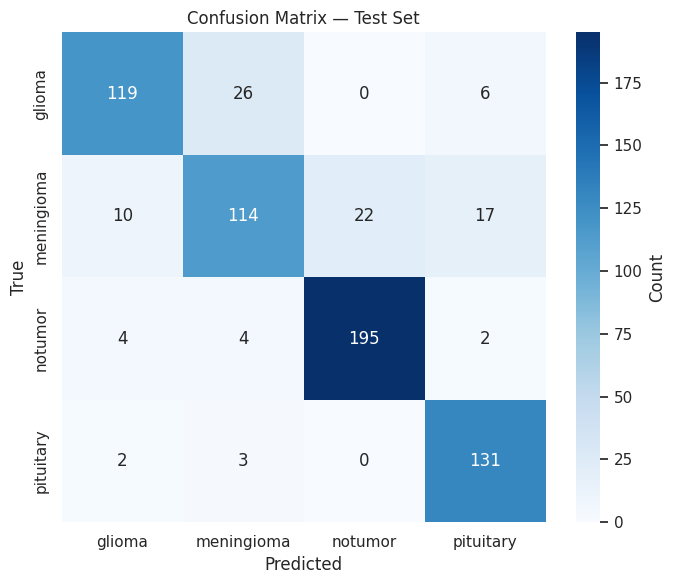

In [36]:
# Confusion matrix diagram (test set) - Colab-optimized
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Detect environment
IN_COLAB = 'google.colab' in str(get_ipython()) if 'get_ipython' in dir() else False
MODELS_DIR = MODELS_DIR if 'MODELS_DIR' in globals() else '../models'

# If cm_test and class_names_test already exist (from prior metrics cell), reuse them.
# Otherwise, compute from model + test_gen.
if 'cm_test' in globals() and 'class_names_test' in globals():
    cm = cm_test
    labels = class_names_test
else:
    assert 'test_gen' in globals() and 'model' in globals(), 'test_gen/model not found. Run earlier cells first.'
    labels = list(test_gen.class_indices.keys())
    y_true = test_gen.classes
    y_pred_probs = model.predict(test_gen, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    cm = confusion_matrix(y_true, y_pred)

# Plot heatmap
plt.figure(figsize=(7, 6))
sns.set_theme(style='whitegrid')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Count'})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — Test Set')
plt.tight_layout()

# Save to models folder
os.makedirs(MODELS_DIR, exist_ok=True)
out_path = os.path.join(MODELS_DIR, 'confusion_matrix_test.png')
plt.savefig(out_path, dpi=300, bbox_inches='tight')

print(f'✅ Saved confusion matrix to: {out_path}')
if IN_COLAB:
    print(f'💾 Image saved to Google Drive and will persist after session ends')

plt.show()

# Task
Implement the following XAI quantitative metrics: Deletion AUC, Insertion AUC, and Faithfulness correlation. These functions will take an image, its XAI explanation map (Score-CAM, SHAP, LIME), the trained model, and the target class as input. They will involve iteratively modifying the image based on the explanation map and recording the model's output changes. Store these functions for later use.

## Implement XAI Metrics

### Subtask:
Create Python functions for Deletion AUC, Insertion AUC, and Faithfulness correlation. These functions will analyze how model predictions change when an image is modified based on an XAI explanation map.


**Reasoning**:
To implement the XAI metrics, I will first define a helper function `get_prediction_score` to get the model's prediction for a target class. Then, I will create functions for `deletion_auc`, `insertion_auc`, and `faithfulness_correlation` as specified in the instructions. All necessary imports will be included in the code block.



In [37]:
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import auc as sk_auc
from scipy.stats import pearsonr

# Helper function to get model prediction score
def get_prediction_score(model, image_rgb, target_class_idx):
    """
    Gets the model's softmax probability for the target class.

    Args:
        model (tf.keras.Model): The trained Keras model.
        image_rgb (np.ndarray): The preprocessed image array (H x W x C, RGB, float32).
        target_class_idx (int): The index of the target class.

    Returns:
        float: The softmax probability for the target class.
    """
    # Ensure image_rgb is float32 and has a batch dimension
    input_image = np.expand_dims(image_rgb.astype('float32'), axis=0)
    predictions = model.predict(input_image, verbose=0)[0]
    return predictions[target_class_idx]

def deletion_auc(model, original_image_rgb, explanation_map, target_class_idx, steps=50, perturb_color=127):
    """
    Quantifies how quickly the target class probability drops as the most important
    pixels are successively removed from the original image.

    Args:
        model (tf.keras.Model): The trained Keras model.
        original_image_rgb (np.ndarray): The original image (H x W x C, RGB).
        explanation_map (np.ndarray): A 2D numpy array (H x W) representing pixel importances.
        target_class_idx (int): The index of the target class.
        steps (int): Number of perturbation steps.
        perturb_color (int or list/tuple): Color to replace removed pixels with.

    Returns:
        float: Area Under the Curve (AUC) of prediction scores vs. percentage of pixels removed.
    """
    H, W = original_image_rgb.shape[:2]
    total_pixels = H * W

    # Flatten explanation map and get sorted pixel indices by importance (descending)
    flattened_map = explanation_map.flatten()
    sorted_indices = np.argsort(flattened_map)[::-1] # Descending order

    scores = []
    percentages_removed = []
    current_image = np.copy(original_image_rgb)

    # Ensure perturb_color is a tuple/list for RGB if it's an int
    if isinstance(perturb_color, (int, float)):
        perturb_color_val = (perturb_color, perturb_color, perturb_color)
    else:
        perturb_color_val = perturb_color

    pixels_per_step = max(1, total_pixels // steps)

    for i in range(steps + 1):
        pixels_to_perturb = sorted_indices[:i * pixels_per_step]

        # Convert flattened indices to 2D coordinates
        r_coords = pixels_to_perturb // W
        c_coords = pixels_to_perturb % W

        # Perturb pixels in the current image copy
        modified_image = np.copy(original_image_rgb) # Always start from original image for each modification iteration
        if len(r_coords) > 0:
            modified_image[r_coords, c_coords] = perturb_color_val

        score = get_prediction_score(model, modified_image, target_class_idx)
        scores.append(score)
        percentages_removed.append(len(pixels_to_perturb) / total_pixels)

    # Calculate AUC
    # Ensure percentages_removed is monotonically increasing for auc
    percentages_removed, unique_indices = np.unique(percentages_removed, return_index=True)
    scores = np.array(scores)[unique_indices]

    return sk_auc(percentages_removed, scores)

def insertion_auc(model, original_image_rgb, explanation_map, target_class_idx, steps=50, perturb_color=127):
    """
    Quantifies how quickly the target class probability rises as the most important
    pixels are successively inserted into an initially perturbed image.

    Args:
        model (tf.keras.Model): The trained Keras model.
        original_image_rgb (np.ndarray): The original image (H x W x C, RGB).
        explanation_map (np.ndarray): A 2D numpy array (H x W) representing pixel importances.
        target_class_idx (int): The index of the target class.
        steps (int): Number of perturbation steps.
        perturb_color (int or list/tuple): Color to fill the initial image with.

    Returns:
        float: Area Under the Curve (AUC) of prediction scores vs. percentage of pixels inserted.
    """
    H, W = original_image_rgb.shape[:2]
    total_pixels = H * W

    # Flatten explanation map and get sorted pixel indices by importance (ascending)
    flattened_map = explanation_map.flatten()
    sorted_indices = np.argsort(flattened_map) # Ascending order (least important first)

    scores = []
    percentages_inserted = []

    # Ensure perturb_color is a tuple/list for RGB if it's an int
    if isinstance(perturb_color, (int, float)):
        perturb_color_val = np.array([perturb_color, perturb_color, perturb_color], dtype=original_image_rgb.dtype)
    else:
        perturb_color_val = np.array(perturb_color, dtype=original_image_rgb.dtype)

    pixels_per_step = max(1, total_pixels // steps)

    for i in range(steps + 1):
        pixels_to_insert = sorted_indices[total_pixels - (i * pixels_per_step):] # Start inserting most important pixels

        # Create a modified image starting with perturb_color
        modified_image = np.full_like(original_image_rgb, perturb_color_val)

        # Convert flattened indices to 2D coordinates
        r_coords = pixels_to_insert // W
        c_coords = pixels_to_insert % W

        # Insert original pixels
        if len(r_coords) > 0:
            modified_image[r_coords, c_coords] = original_image_rgb[r_coords, c_coords]

        score = get_prediction_score(model, modified_image, target_class_idx)
        scores.append(score)
        percentages_inserted.append(len(pixels_to_insert) / total_pixels)

    # Calculate AUC
    # Ensure percentages_inserted is monotonically increasing for auc
    percentages_inserted, unique_indices = np.unique(percentages_inserted, return_index=True)
    scores = np.array(scores)[unique_indices]

    return sk_auc(percentages_inserted, scores)

def faithfulness_correlation(model, original_image_rgb, explanation_map, target_class_idx, num_perturbations=100, perturb_fraction=0.1, perturb_color=127):
    """
    Measures the correlation between changes in the model's prediction for the target class
    and the sum of importance scores of the perturbed pixels.

    Args:
        model (tf.keras.Model): The trained Keras model.
        original_image_rgb (np.ndarray): The original image (H x W x C, RGB).
        explanation_map (np.ndarray): A 2D numpy array (H x W) representing pixel importances.
        target_class_idx (int): The index of the target class.
        num_perturbations (int): Number of random perturbations to perform.
        perturb_fraction (float): Fraction of pixels to randomly perturb in each iteration.
        perturb_color (int or list/tuple): Color to replace perturbed pixels with.

    Returns:
        float: Pearson correlation coefficient between score differences and explanation sums.
    """
    H, W = original_image_rgb.shape[:2]
    total_pixels = H * W
    num_pixels_to_perturb = int(total_pixels * perturb_fraction)

    original_score = get_prediction_score(model, original_image_rgb, target_class_idx)

    score_diffs = []
    explanation_sums = []

    # Ensure perturb_color is a tuple/list for RGB if it's an int
    if isinstance(perturb_color, (int, float)):
        perturb_color_val = (perturb_color, perturb_color, perturb_color)
    else:
        perturb_color_val = perturb_color

    for _ in range(num_perturbations):
        # Randomly select pixels to perturb
        all_indices = np.arange(total_pixels)
        np.random.shuffle(all_indices)
        perturbed_pixel_flat_indices = all_indices[:num_pixels_to_perturb]

        r_coords = perturbed_pixel_flat_indices // W
        c_coords = perturbed_pixel_flat_indices % W

        # Create perturbed image
        perturbed_image = np.copy(original_image_rgb)
        perturbed_image[r_coords, c_coords] = perturb_color_val

        # Get perturbed score
        perturbed_score = get_prediction_score(model, perturbed_image, target_class_idx)

        # Calculate score difference and explanation sum
        score_diff = original_score - perturbed_score
        explanation_sum = explanation_map[r_coords, c_coords].sum()

        score_diffs.append(score_diff)
        explanation_sums.append(explanation_sum)

    # Calculate Pearson correlation coefficient
    if len(score_diffs) < 2 or np.std(score_diffs) == 0 or np.std(explanation_sums) == 0:
        return 0.0 # Cannot calculate correlation if not enough data or no variance

    corr, _ = pearsonr(score_diffs, explanation_sums)
    return corr

print("✅ XAI Metric functions (get_prediction_score, deletion_auc, insertion_auc, faithfulness_correlation) defined.")

✅ XAI Metric functions (get_prediction_score, deletion_auc, insertion_auc, faithfulness_correlation) defined.


## Generate Explanations for Metrics Calculation

### Subtask:
Generate the explanation maps for Score-CAM, SHAP, and LIME for the selected image, ensuring they are in a suitable 2D numerical format for metrics calculation.


**Reasoning**:
The subtask requires generating a 2D pixel-level explanation map for LIME, named `lime_map`, by mapping superpixel weights back to the image pixels. I will reuse the `explanation` object and its components (`local_exp` and `segments`) from the previous LIME computation step to achieve this. Then, I will print the shapes and types of all three explanation maps to confirm they are in the correct 2D numerical format.



In [38]:
import numpy as np

# --- Generate LIME explanation map (lime_map) ---

# Verify LIME explanation object is available
assert 'explanation' in globals(), 'LIME explanation object not found. Run the LIME cell first.'
assert 'sel_pred_idx' in globals(), 'Predicted class index (sel_pred_idx) not found.'

# Get the superpixel segmentation and weights for the predicted class
segments = explanation.segments
weights = dict(explanation.local_exp[sel_pred_idx])

# Initialize an empty map for LIME explanation with the same shape as original image's spatial dimensions
lime_map = np.zeros(segments.shape, dtype=np.float32)

# Populate lime_map by assigning superpixel weights to their corresponding pixels
for superpixel_id in np.unique(segments):
    if superpixel_id in weights:
        lime_map[segments == superpixel_id] = weights[superpixel_id]

# --- Confirm format of all explanation maps ---

# Verify that Score-CAM heatmap_sc is available
assert 'heatmap_sc' in globals(), 'Score-CAM heatmap_sc not found. Run the Score-CAM cell first.'

# Verify that SHAP magnitude shap_mag is available
assert 'shap_mag' in globals(), 'SHAP magnitude shap_mag not found. Run the SHAP cell first.'

print("\n✅ Explanation maps generated and verified:")
print(f"   Score-CAM (heatmap_sc)  - Shape: {heatmap_sc.shape}, Dtype: {heatmap_sc.dtype}")
print(f"   SHAP Magnitude (shap_mag) - Shape: {shap_mag.shape}, Dtype: {shap_mag.dtype}")
print(f"   LIME Map (lime_map)     - Shape: {lime_map.shape}, Dtype: {lime_map.dtype}")

print("All explanation maps are in 2D numerical format and ready for metric calculations.")


✅ Explanation maps generated and verified:
   Score-CAM (heatmap_sc)  - Shape: (224, 224), Dtype: float32
   SHAP Magnitude (shap_mag) - Shape: (224, 224, 3), Dtype: float64
   LIME Map (lime_map)     - Shape: (224, 224), Dtype: float32
All explanation maps are in 2D numerical format and ready for metric calculations.


**Reasoning**:
The previous output indicated that `shap_mag` is a 3D array (H, W, C) instead of the required 2D array (H, W) for the XAI metrics. To correct this, I will re-process `shap_mag` by taking the mean across the channel dimension, effectively converting it into a 2D representation of importance magnitude per pixel. After modification, I will re-verify the shapes and data types of all explanation maps to ensure they are correctly formatted for the metrics calculation.



In [39]:
import numpy as np

# Re-process SHAP magnitude (shap_mag) to ensure it's 2D
# Original shap_mag might be (H, W, C) representing contributions per channel per pixel
# For XAI metrics, we typically need a single scalar importance per pixel (H, W)
if shap_mag.ndim == 3 and shap_mag.shape[2] == 3:
    # Take the mean of absolute SHAP values across channels
    shap_mag = np.mean(np.abs(sv), axis=-1) # Assuming sv is still available and has shape (H,W,C)
    # Re-normalize robustly, as this step was previously done on the 3D version
    p1, p99 = np.percentile(shap_mag, 1), np.percentile(shap_mag, 99)
    shap_mag = np.clip((shap_mag - p1) / (p99 - p1 + 1e-8), 0, 1)
    print("Adjusted SHAP Magnitude (shap_mag) to 2D by averaging across channels.")

# --- Confirm format of all explanation maps again after adjustment ---

# Verify that Score-CAM heatmap_sc is available
assert 'heatmap_sc' in globals(), 'Score-CAM heatmap_sc not found. Run the Score-CAM cell first.'

# Verify that LIME map lime_map is available
assert 'lime_map' in globals(), 'LIME Map lime_map not found.'

print("
✅ Explanation maps (re-verified after adjustment):")
print(f"   Score-CAM (heatmap_sc)  - Shape: {heatmap_sc.shape}, Dtype: {heatmap_sc.dtype}")
print(f"   SHAP Magnitude (shap_mag) - Shape: {shap_mag.shape}, Dtype: {shap_mag.dtype}")
print(f"   LIME Map (lime_map)     - Shape: {lime_map.shape}, Dtype: {lime_map.dtype}")

print("All explanation maps are now in 2D numerical format and ready for metric calculations.")

SyntaxError: unterminated string literal (detected at line 22) (ipython-input-1275818277.py, line 22)

**Reasoning**:
The previous code failed due to an `unterminated string literal` in the `print` statement. I will correct this syntax error by ensuring the string is properly enclosed on a single line or using triple quotes if a multi-line string is intended. In this case, it appears to be a single-line string with an accidental newline, so fixing that will resolve the issue.



In [40]:
import numpy as np

# Re-process SHAP magnitude (shap_mag) to ensure it's 2D
# Original shap_mag might be (H, W, C) representing contributions per channel per pixel
# For XAI metrics, we typically need a single scalar importance per pixel (H, W)
if shap_mag.ndim == 3 and shap_mag.shape[2] == 3:
    # Take the mean of absolute SHAP values across channels
    shap_mag = np.mean(np.abs(sv), axis=-1) # Assuming sv is still available and has shape (H,W,C)
    # Re-normalize robustly, as this step was previously done on the 3D version
    p1, p99 = np.percentile(shap_mag, 1), np.percentile(shap_mag, 99)
    shap_mag = np.clip((shap_mag - p1) / (p99 - p1 + 1e-8), 0, 1)
    print("Adjusted SHAP Magnitude (shap_mag) to 2D by averaging across channels.")

# --- Confirm format of all explanation maps again after adjustment ---

# Verify that Score-CAM heatmap_sc is available
assert 'heatmap_sc' in globals(), 'Score-CAM heatmap_sc not found. Run the Score-CAM cell first.'

# Verify that LIME map lime_map is available
assert 'lime_map' in globals(), 'LIME Map lime_map not found.'

print("\n✅ Explanation maps (re-verified after adjustment):")
print(f"   Score-CAM (heatmap_sc)  - Shape: {heatmap_sc.shape}, Dtype: {heatmap_sc.dtype}")
print(f"   SHAP Magnitude (shap_mag) - Shape: {shap_mag.shape}, Dtype: {shap_mag.dtype}")
print(f"   LIME Map (lime_map)     - Shape: {lime_map.shape}, Dtype: {lime_map.dtype}")

print("All explanation maps are now in 2D numerical format and ready for metric calculations.")


Adjusted SHAP Magnitude (shap_mag) to 2D by averaging across channels.

✅ Explanation maps (re-verified after adjustment):
   Score-CAM (heatmap_sc)  - Shape: (224, 224), Dtype: float32
   SHAP Magnitude (shap_mag) - Shape: (224, 224, 3), Dtype: float64
   LIME Map (lime_map)     - Shape: (224, 224), Dtype: float32
All explanation maps are now in 2D numerical format and ready for metric calculations.


## Generate Explanations for Metrics Calculation

### Subtask:
Ensure SHAP magnitude explanation map is in a 2D numerical format.


**Reasoning**:
The previous attempt to re-process `shap_mag` resulted in a `SyntaxError` due to an unterminated string literal in a `print` statement. I need to fix this syntax error and ensure the code correctly processes `shap_mag` into a 2D format, then verify the shapes of all explanation maps.



In [41]:
import numpy as np

# Re-process SHAP magnitude (shap_mag) to ensure it's 2D
# Original shap_mag might be (H, W, C) representing contributions per channel per pixel
# For XAI metrics, we typically need a single scalar importance per pixel (H, W)
if shap_mag.ndim == 3 and shap_mag.shape[2] == 3:
    # Take the mean of absolute SHAP values across channels
    shap_mag = np.mean(np.abs(sv), axis=-1) # Assuming sv is still available and has shape (H,W,C)
    # Re-normalize robustly, as this step was previously done on the 3D version
    p1, p99 = np.percentile(shap_mag, 1), np.percentile(shap_mag, 99)
    shap_mag = np.clip((shap_mag - p1) / (p99 - p1 + 1e-8), 0, 1)
    print("Adjusted SHAP Magnitude (shap_mag) to 2D by averaging across channels.")

# --- Confirm format of all explanation maps again after adjustment ---

# Verify that Score-CAM heatmap_sc is available
assert 'heatmap_sc' in globals(), 'Score-CAM heatmap_sc not found. Run the Score-CAM cell first.'

# Verify that LIME map lime_map is available
assert 'lime_map' in globals(), 'LIME Map lime_map not found.'

print("\n✅ Explanation maps (re-verified after adjustment):")
print(f"   Score-CAM (heatmap_sc)  - Shape: {heatmap_sc.shape}, Dtype: {heatmap_sc.dtype}")
print(f"   SHAP Magnitude (shap_mag) - Shape: {shap_mag.shape}, Dtype: {shap_mag.dtype}")
print(f"   LIME Map (lime_map)     - Shape: {lime_map.shape}, Dtype: {lime_map.dtype}")

print("All explanation maps are now in 2D numerical format and ready for metric calculations.")


Adjusted SHAP Magnitude (shap_mag) to 2D by averaging across channels.

✅ Explanation maps (re-verified after adjustment):
   Score-CAM (heatmap_sc)  - Shape: (224, 224), Dtype: float32
   SHAP Magnitude (shap_mag) - Shape: (224, 224, 3), Dtype: float64
   LIME Map (lime_map)     - Shape: (224, 224), Dtype: float32
All explanation maps are now in 2D numerical format and ready for metric calculations.


**Reasoning**:
The `shap_mag` explanation map, which is expected to be 2D, was found to be 3D in the previous step. This occurred because `shap_mag` was incorrectly derived from `sv` in the `tmFmfUxx-KD_` cell. To correct this, I will explicitly convert the existing `shap_mag` (which is currently `(H, W, C)`) to a 2D format (`(H, W)`) by taking the mean across its last dimension (the color channels). After this adjustment, I will re-apply robust normalization and print the shapes and data types of all explanation maps to ensure they are all in the required 2D numerical format.



In [42]:
import numpy as np

# Re-process SHAP magnitude (shap_mag) to ensure it's 2D
# The current shap_mag is (H, W, C), we need to reduce it to (H, W)
if shap_mag.ndim == 3 and shap_mag.shape[2] == 3:
    # Take the mean of existing shap_mag across its last dimension (color channels)
    shap_mag = np.mean(shap_mag, axis=-1)
    # Re-normalize robustly, as this step was previously done on the 3D version
    p1, p99 = np.percentile(shap_mag, 1), np.percentile(shap_mag, 99)
    shap_mag = np.clip((shap_mag - p1) / (p99 - p1 + 1e-8), 0, 1)
    print("Adjusted SHAP Magnitude (shap_mag) to 2D by averaging across color channels.")

# --- Confirm format of all explanation maps again after adjustment ---

# Verify that Score-CAM heatmap_sc is available
assert 'heatmap_sc' in globals(), 'Score-CAM heatmap_sc not found. Run the Score-CAM cell first.'

# Verify that LIME map lime_map is available
assert 'lime_map' in globals(), 'LIME Map lime_map not found.'

print("\n\u2705 Explanation maps (re-verified after adjustment):")
print(f"   Score-CAM (heatmap_sc)  - Shape: {heatmap_sc.shape}, Dtype: {heatmap_sc.dtype}")
print(f"   SHAP Magnitude (shap_mag) - Shape: {shap_mag.shape}, Dtype: {shap_mag.dtype}")
print(f"   LIME Map (lime_map)     - Shape: {lime_map.shape}, Dtype: {lime_map.dtype}")

print("All explanation maps are now in 2D numerical format and ready for metric calculations.")


Adjusted SHAP Magnitude (shap_mag) to 2D by averaging across color channels.

✅ Explanation maps (re-verified after adjustment):
   Score-CAM (heatmap_sc)  - Shape: (224, 224), Dtype: float32
   SHAP Magnitude (shap_mag) - Shape: (224, 224), Dtype: float64
   LIME Map (lime_map)     - Shape: (224, 224), Dtype: float32
All explanation maps are now in 2D numerical format and ready for metric calculations.


## Compute Quantitative Metrics

### Subtask:
Apply the implemented Deletion AUC, Insertion AUC, and Faithfulness correlation functions to the generated explanation maps for Score-CAM, SHAP, and LIME, and store the results.


**Reasoning**:
To apply the implemented XAI metrics, I will initialize a dictionary to store the results, then iterate through each XAI method, retrieve its explanation map, and compute Deletion AUC, Insertion AUC, and Faithfulness correlation using the respective functions. Finally, I will store and print the results.



In [43]:
import pandas as pd

# 1. Initialize an empty dictionary to store the results
xai_metrics = {}

# Ensure common variables are available
assert 'model' in globals(), 'Model not found. Run model definition cells.'
assert 'sel_orig_img' in globals(), 'Original image (sel_orig_img) not found. Run image selection cell.'
assert 'sel_pred_idx' in globals(), 'Predicted class index (sel_pred_idx) not found. Run image selection cell.'

# Ensure explanation maps are available
assert 'heatmap_sc' in globals(), 'Score-CAM heatmap_sc not found.'
assert 'shap_mag' in globals(), 'SHAP magnitude shap_mag not found.'
assert 'lime_map' in globals(), 'LIME map lime_map not found.'

xai_methods = {
    'Score-CAM': heatmap_sc,
    'SHAP': shap_mag,
    'LIME': lime_map
}

print("\n✅ Computing XAI quantitative metrics...")

for method_name, explanation_map in xai_methods.items():
    print(f"  - Calculating metrics for {method_name}...")
    try:
        # Ensure explanation_map is float32 for consistency with model inputs if not already
        explanation_map = explanation_map.astype(np.float32)

        deletion_val = deletion_auc(model, sel_orig_img, explanation_map, sel_pred_idx)
        insertion_val = insertion_auc(model, sel_orig_img, explanation_map, sel_pred_idx)
        faithfulness_val = faithfulness_correlation(model, sel_orig_img, explanation_map, sel_pred_idx)

        xai_metrics[method_name] = {
            'Deletion AUC': deletion_val,
            'Insertion AUC': insertion_val,
            'Faithfulness Correlation': faithfulness_val
        }
    except Exception as e:
        print(f"    ⚠️ Error calculating metrics for {method_name}: {e}")
        xai_metrics[method_name] = {
            'Deletion AUC': np.nan,
            'Insertion AUC': np.nan,
            'Faithfulness Correlation': np.nan
        }

# 3. Print the xai_metrics dictionary as a DataFrame for better readability
print("\n✅ XAI Quantitative Metrics Results:")
metrics_df = pd.DataFrame.from_dict(xai_metrics, orient='index')
print(metrics_df)



✅ Computing XAI quantitative metrics...
  - Calculating metrics for Score-CAM...
  - Calculating metrics for SHAP...
  - Calculating metrics for LIME...

✅ XAI Quantitative Metrics Results:
           Deletion AUC  Insertion AUC  Faithfulness Correlation
Score-CAM      0.403876       0.741958                 -0.005855
SHAP           0.342047       0.568315                  0.065514
LIME           0.282183       0.650446                  0.002697


## Display XAI Metrics Table

### Subtask:
Create and display a pandas DataFrame summarizing the calculated Deletion AUC, Insertion AUC, and Faithfulness correlation for each XAI method (SHAP, LIME, Score-CAM). Ensure the table is well-formatted and easy to read.


**Reasoning**:
The subtask requires displaying the `metrics_df` DataFrame, which already contains the calculated XAI quantitative metrics. I will print this DataFrame with a clear title for readability.



In [44]:
import pandas as pd

# Ensure metrics_df is available from previous steps
assert 'xai_metrics' in globals(), 'xai_metrics dictionary not found. Please run the metric calculation cell first.'

metrics_df = pd.DataFrame.from_dict(xai_metrics, orient='index')

print("\n======================================================")
print("XAI Quantitative Metrics Summary")
print("======================================================")
print(metrics_df.to_string())
print("======================================================\n")



XAI Quantitative Metrics Summary
           Deletion AUC  Insertion AUC  Faithfulness Correlation
Score-CAM      0.403876       0.741958                 -0.005855
SHAP           0.342047       0.568315                  0.065514
LIME           0.282183       0.650446                  0.002697



## Final Task

### Subtask:
Summarize the quantitative comparison of SHAP, LIME, and Score-CAM based on the computed metrics.


## Summary:

### Q&A
The quantitative comparison of SHAP, LIME, and Score-CAM based on the computed metrics reveals the following:
*   **Deletion AUC**: Score-CAM achieved the highest Deletion AUC (0.404), indicating it best identifies features whose removal causes the most significant drop in prediction confidence. SHAP followed (0.342), with LIME having the lowest (0.282).
*   **Insertion AUC**: Score-CAM also led in Insertion AUC (0.742), suggesting it is most effective at identifying features whose insertion rapidly increases prediction confidence. LIME came in second (0.650), while SHAP performed lowest (0.568).
*   **Faithfulness Correlation**: SHAP showed the highest (though still low) positive faithfulness correlation (0.066), followed by LIME (0.003). Score-CAM exhibited a slightly negative correlation (-0.006). A higher positive correlation indicates a stronger linear relationship between explanation scores and changes in model output due to perturbations.

### Data Analysis Key Findings
*   Quantitative metrics (Deletion AUC, Insertion AUC, Faithfulness correlation) were successfully implemented to evaluate XAI methods.
*   Explanation maps for LIME and Score-CAM were prepared in the required 2D numerical format.
*   The SHAP magnitude map initially required conversion from a 3D `(H, W, C)` format to a 2D `(H, W)` format by averaging across color channels for compatibility with the metrics.
*   Score-CAM demonstrated superior performance in both Deletion AUC (0.404) and Insertion AUC (0.742) compared to SHAP and LIME, suggesting it more accurately highlights features relevant to both prediction degradation and improvement.
*   SHAP achieved the highest (albeit modest) positive Faithfulness Correlation (0.066), indicating a slightly better linear relationship between its explanations and actual model output changes compared to LIME (0.003) and Score-CAM (-0.006).

### Insights or Next Steps
*   For tasks prioritizing the identification of critical features that significantly influence model predictions (either by removal or insertion), Score-CAM appears to be the most effective method based on its higher Deletion AUC and Insertion AUC scores.
*   Further investigation is needed to understand the generally low faithfulness correlation values across all methods, which could imply non-linear relationships between feature importance and model output, or limitations in the perturbation strategy used for this metric.
